# Survivor Season 1 Network Anaysis

In [73]:
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

### Things we can add

 - add in node size/color edge size/color in the functions
 - add functions to do EDA on the merged sub data set?
 - add in sentiment into the network
 - do general summary statistics on merged sub data set?
      - look at how the summary statistics change over the course of the season post-merge
 - do a GIF file?
      - do a GIF file of the season episode by episode
 - experiment with community searching?
 - plot the final tribal council vote
 - add alliance linakges
      - manual work to compile to feed into the functions (Lenny)
 - pull two more seasons and do comparison
      - of networks
      - of summary statistics
 - metrics? (self-made?)

### Import stats data

In [74]:
seasonstats = pd.read_csv("../data/season_1/stats_season_1.csv")

In [75]:
(seasonstats.columns)

Index(['Season', 'Episode', 'Contestants', 'ChW', 'ChA', 'SO', 'VFB', 'VAP',
       'TotV', 'TCA', 'TCV', 'VFT', 'InRCA', 'InRCW', 'InICA', 'InICW', 'TRCA',
       'TRCW', 'TICA', 'TICW', 'Reward win?', 'Reward #people', 'Reward win%',
       'Immunity win', 'Immunity #people', 'Immunity win%',
       'Immunity total win%', 'Sex', 'Age', 'Occupation', 'Hometown',
       'Home State', 'Original Tribe', 'Merged', 'Tribe'],
      dtype='object')

In [30]:
def returnImmunityTribeResult(res, df):
    '''
    PARAMETERS
    res: str
        res is the result of that tribes immunity challenge. It is either win or lose.
    df: DataFrame
        df is subset of the season statistics filtered by tribe and episode.
        
    RETURNS
        either a undirected fully connected graph if the tribe won immunity challenge 
        or a directed graph of the losing tribe's voting ceremony
    '''
    if res == 'win':
        e = []
        immune = df["Contestants"].unique()
        for i in range(len(immune)):
            for j in range(len(immune)):
                if i != j:
                    e.append((immune[i],immune[j]))
        G = nx.Graph()
        G.add_edges_from(e)
    elif res == 'lose':
        tribal = df[['Contestants','TCV']]
        tr = list(tribal.itertuples(index=False, name=None))
        G = nx.DiGraph()
        G.add_edges_from(tr)
        
    return G

In [140]:
def getNodeColor(G,nodecolor):
    groups = set(nx.get_node_attributes(G,nodecolor).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = G.nodes()
    colors = [mapping[G.nodes[n][nodecolor]] for n in nodes]
    return colors
    

In [145]:
def getNodeSize(G,nodesize):
    groups = set(nx.get_node_attributes(G,nodesize).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = G.nodes()
    size = [mapping[G.nodes[n][nodesize]] for n in nodes]
    return size

In [157]:
def plotPreMerged(seasonstats, nodecolor=None, nodesize=None):
    '''
    PARAMETERS
        seasonstats: DataFrame
            seasonstats is the raw data input read in from the Survivor season statistics
        nodecolor: str
            a column name to color the nodes of the network
        
    RETURNS
        plots each tribe's network for each episode, two networks per figure: 
        a directional graph if a tribe had to go to tribal council
        an undirected fully connected graph if a tribe won immunity challenge
    '''
    season = str(seasonstats['Season'].unique()[0])
    immunityresults = pd.pivot_table(seasonstats[seasonstats['Merged'] == False], values='TICW', index=['Episode'],columns=['Original Tribe'], aggfunc=np.sum)
    tribeList = immunityresults.reset_index(drop=True).columns.to_list()
    
    for i in tribeList:
        immunityresults[i] = immunityresults[i].apply(lambda x: 'lose' if x == 0 else 'win')
        
    tribeCh = list(immunityresults.itertuples(index=True, name=None))
    for i in range(len(tribeCh)):
        # for each episode, get the two tribes subset of statistics
        ep_tribe1 = seasonstats[(seasonstats['Tribe'] == tribeList[0]) & (seasonstats['Episode'] == i+1)]
        ep_tribe2 = seasonstats[(seasonstats['Tribe'] == tribeList[1]) & (seasonstats['Episode'] == i+1)]

        # use returnImmunityTribeResult to return a winning/losing network
        tribe1 = returnImmunityTribeResult(tribeCh[i][1], ep_tribe1)
        tribe2 = returnImmunityTribeResult(tribeCh[i][2], ep_tribe2)

        fig = plt.figure(figsize=(15, 6))
        fig.suptitle('Survivor Season ' + season + ' Episode ' + str(i+1))
        
        # set left side of the two tribes
        
        nx.set_node_attributes(tribe1, getNodeAttributes(seasonstats))
        
        if nodecolor is not None:
            tribe1nodecolor = getNodeColor(tribe1,nodecolor)
            cmap=plt.cm.get_cmap('Blues')
        else:
            tribe1nodecolor = None
            cmap=None
            
        if nodesize is not None:
            tribe1nodesize = getNodeSize(tribe1,nodesize)
        else:
            tribe1nodesize = None
            
        pos=nx.circular_layout(tribe1)
        
        plt.subplot(1, 2, 1)
        nx.draw(tribe1,
                pos=pos,
                with_labels=True,
                # node_size=tribe1nodesize,
                node_color=tribe1nodecolor,
                cmap=cmap)

        plt.title(tribeList[0]+' Tribe')
        
        # set right side of the two tribes
        
        nx.set_node_attributes(tribe2, getNodeAttributes(seasonstats))
        
        if nodecolor is not None:
            tribe2nodecolor = getNodeColor(tribe2,nodecolor)
            cmap=plt.cm.get_cmap('Blues')
        else:
            tribe2nodecolor = None
            cmap=None
        
        if nodesize is not None:
            tribe2nodesize = getNodeSize(tribe2,nodesize)
        else:
            tribe2nodesize = None

        pos=nx.circular_layout(tribe2)

        plt.subplot(1, 2, 2)
        nx.draw(tribe2,
                pos=pos,
                with_labels=True,
                # node_size=tribe2nodesize,
                node_color=tribe2nodecolor,
                cmap=cmap)
        plt.title(tribeList[1] + ' Tribe')

        plt.show()

In [186]:
def plotMerged(seasonstats,nodecolor):
    '''
    PARAMETERS
        seasonstats: DataFrame
            seasonstats is the full imported dataframe of the season statistics
        nodecolor: str
            a column name to color the nodes of the network
        
    RETURNS
        plots a directional graph of each tribal council for each episode during the merged tribal period
    '''
    epList = seasonstats[(seasonstats['Merged'] == True)]['Episode'].unique()
    season = str(seasonstats['Season'].unique()[0])
    tribeName = seasonstats[(seasonstats['Merged'] == True)]['Tribe'].unique()[0]
    lastEp = max(epList)
    
    for i in range(len(epList)):
        if epList[i] != lastEp:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))

            fig = plt.figure(figsize=(15, 6))

            G = nx.DiGraph()
            G.add_edges_from(indvVotes)
            
            nx.set_node_attributes(G, getNodeAttributes(seasonstats))

            if nodecolor is not None:
                colors = getNodeColor(G,nodecolor)
                cmap=plt.cm.get_cmap('Blues')
            else:
                colors = None
                cmap=None
            
            pos=nx.circular_layout(G)
            
            plt.subplot(1, 1, 1)
            nx.draw(G,
                    pos=pos,
                    with_labels=True,
                    node_color=colors,
                    cmap=cmap)
            
            fig.suptitle(tribeName + " Tribe")
            plt.title('Survivor Season ' + season + ' Episode ' + str(ep))
            plt.show()
        else:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))
            e = []
            
            for i in range(len(indvVotes)):
                if str(indvVotes[i][1]) != 'nan':
                    e.append(indvVotes[i])

            n = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)]['Contestants'].unique()
            
            G = nx.DiGraph()
            G.add_nodes_from(n)
            G.add_edges_from(e)
            nx.set_node_attributes(G, getNodeAttributes(seasonstats))
            
            if nodecolor is not None:
                colors = getNodeColor(G,nodecolor)
                cmap=plt.cm.get_cmap('Blues')
            else:
                colors = None
                cmap=None
            
            pos=nx.circular_layout(G)
            
            fig = plt.figure(figsize=(15, 6))
            fig.suptitle(tribeName + " Tribe")
            plt.subplot(1, 1, 1)
            nx.draw(G,
                    pos=pos,
                    with_labels=True,
                    node_color=colors,
                    cmap=cmap)
            
            plt.title('Survivor Season ' + season + ' Episode ' + str(ep))
            plt.show()

In [188]:
def plotSeasonEpisodes(seasonstats,nodecolor):
    '''
    PARAMETERS
        seasonstats: DataFrame
                seasonstats is the raw data input read in from the Survivor season statistics
        nodecolor: str
            a column name to color the nodes of the network
                
    RETURNS
        A chronological progression of contestants leaving the show
    '''
    plotPreMerged(seasonstats,nodecolor)
    plotMerged(seasonstats,nodecolor)

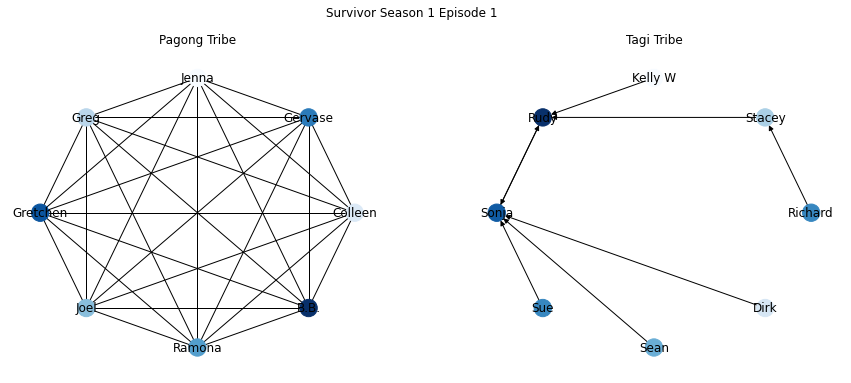

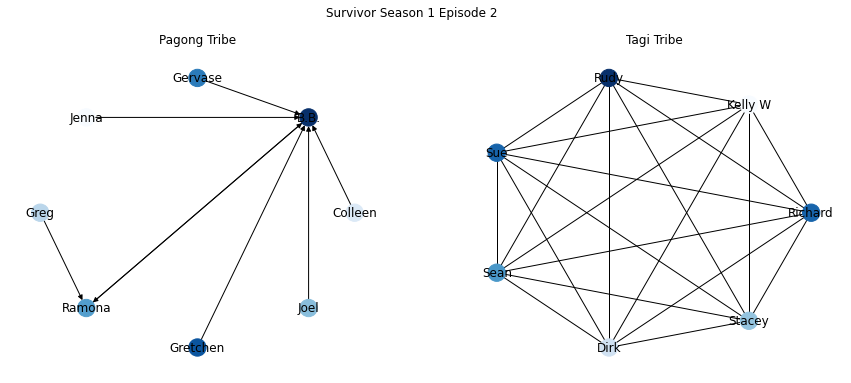

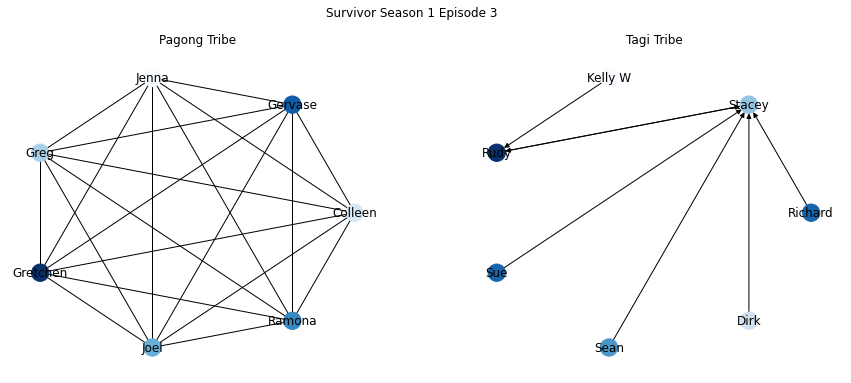

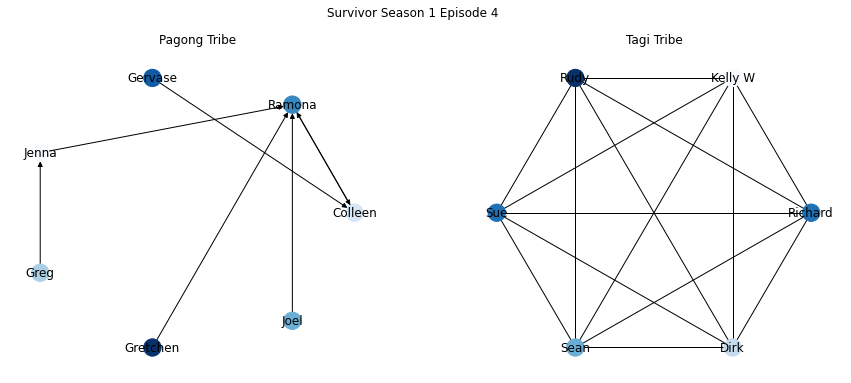

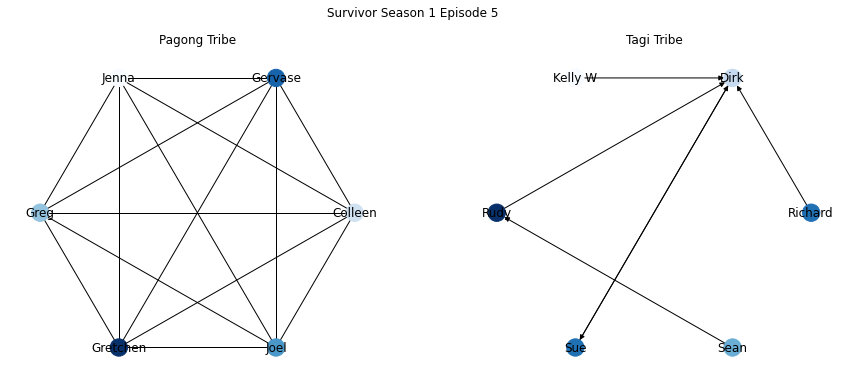

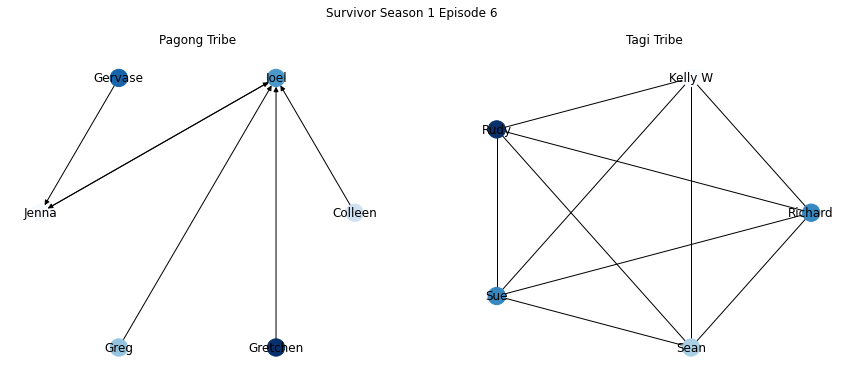

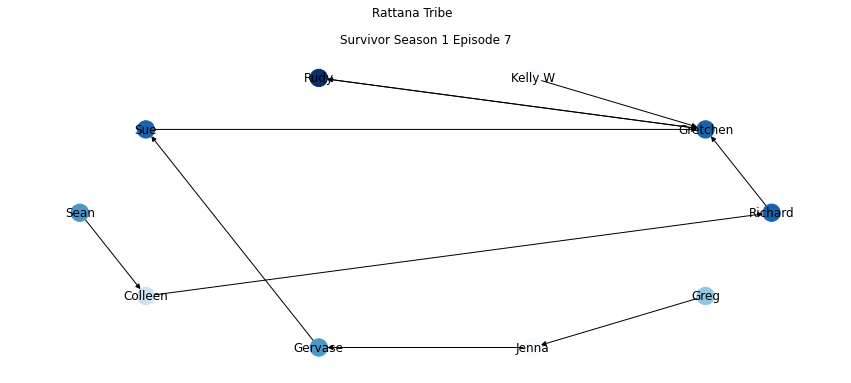

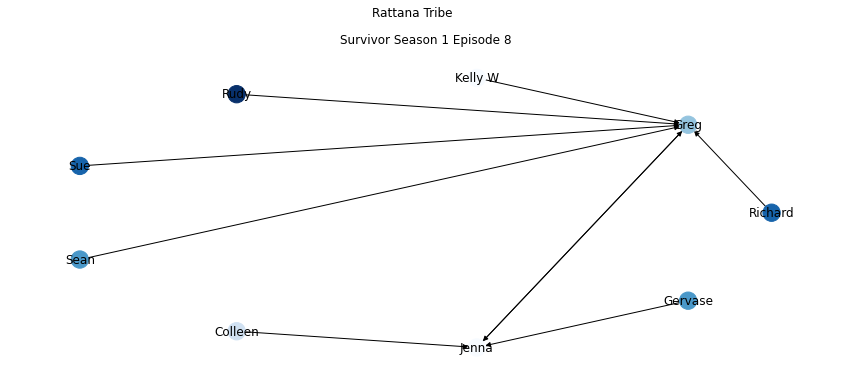

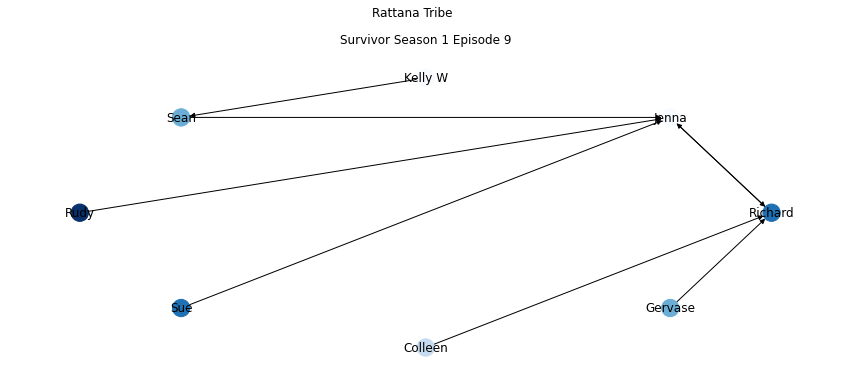

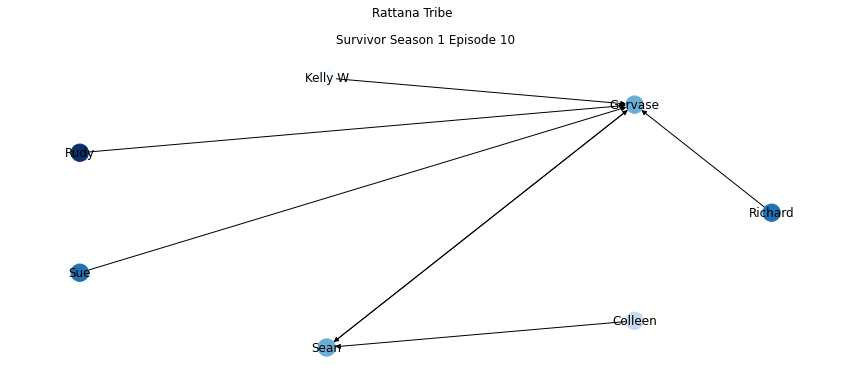

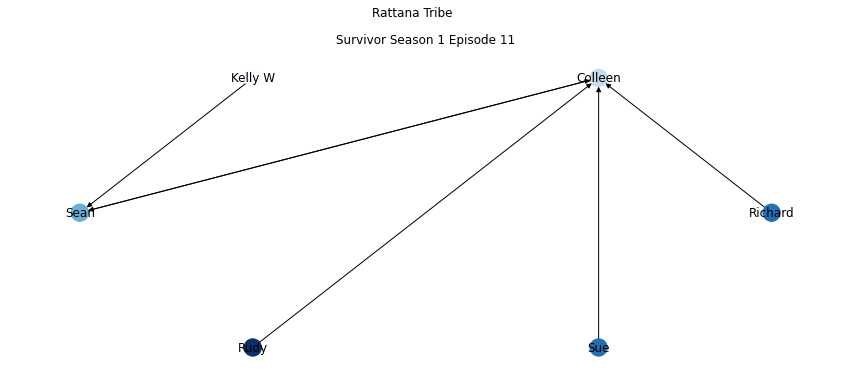

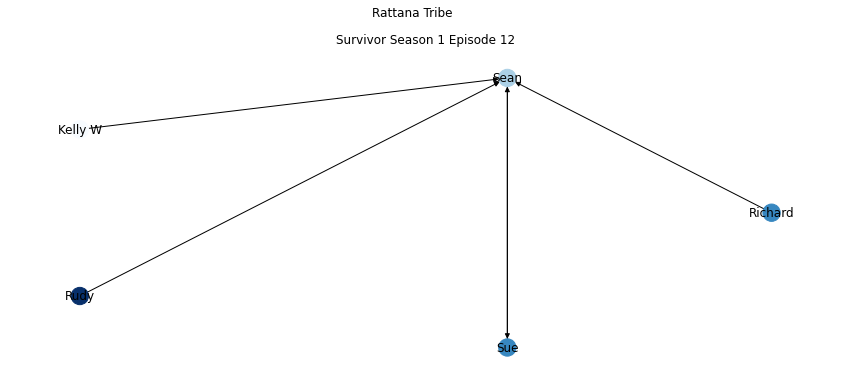

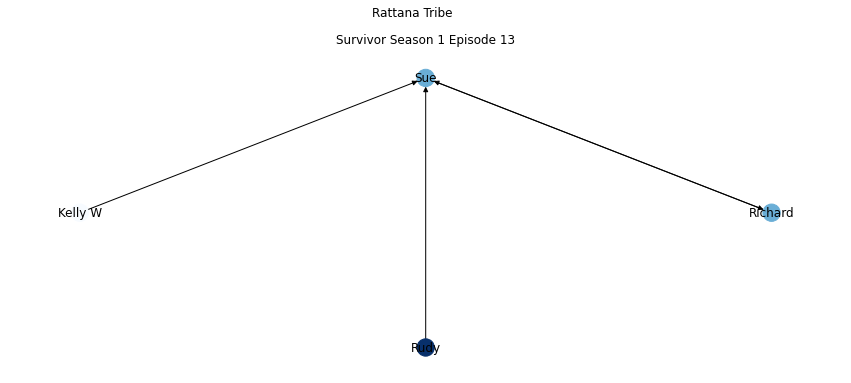

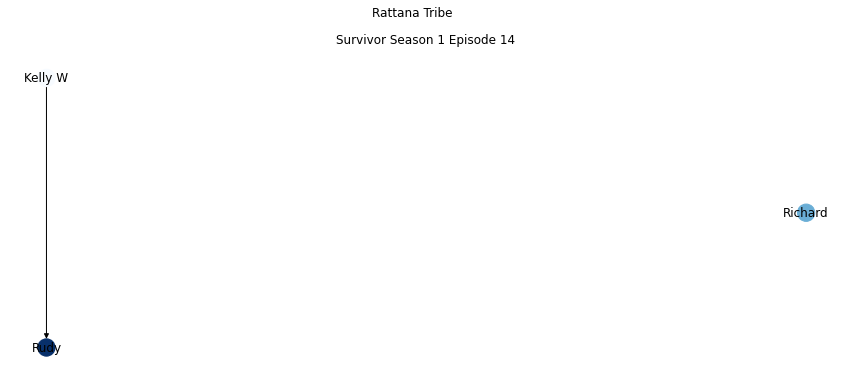

In [189]:
plotSeasonEpisodes(seasonstats,"Age")

In [218]:
def network_summary(G):

    def centrality_stats(x):
        x1=dict(x)
        x2=np.array(list(x1.values())); #print(x2)
        print("	min:" ,min(x2))
        print("	mean:" ,np.mean(x2))
        print("	median:" ,np.median(x2))
        # print("	mode:" ,stats.mode(x2)[0][0])
        print("	max:" ,max(x2))
        x=dict(x)
        sort_dict=dict(sorted(x1.items(), key=lambda item: item[1],reverse=True))
        print("	top nodes:",list(sort_dict)[0:6])
        print("	          ",list(sort_dict.values())[0:6])

    try: 
        print("GENERAL")
        print("	number of nodes:",len(list(G.nodes)))
        print("	number of edges:",len(list(G.edges)))

        print("	is_directed:", nx.is_directed(G))
        print("	is_weighted:" ,nx.is_weighted(G))
        # print("	is_connected:" ,nx.is_connected(G))
        print("	is_tree:" ,nx.is_tree(G))
        # print("	number_connected_components", nx.number_connected_components(G))
        # print("	number of triangle: ",len(nx.triangles(G).keys()))
        print("	density:" ,nx.density(G))
        print("	average_clustering coefficient: ", nx.average_clustering(G))
        print("	degree_assortativity_coefficient: ", nx.degree_assortativity_coefficient(G))

        # if(nx.is_connected(G)):
        #     print("	diameter:" ,nx.diameter(G))
        #     print("	radius:" ,nx.radius(G))
        #     print("	average_shortest_path_length: ", nx.average_shortest_path_length(G))

        #CENTRALITY 
        print("DEGREE")
        centrality_stats(nx.degree(G))

        print("CLOSENESS CENTRALITY")
        centrality_stats(nx.closeness_centrality(G))

        print("BETWEEN CENTRALITY")
        centrality_stats(nx.betweenness_centrality(G))
    except:
        print("unable to run")

In [15]:
def getNodeAttributes(seasonstats):
    f = seasonstats[seasonstats['Episode'] == 1][["Contestants","Sex","Age","Occupation","Home State", "Original Tribe"]]
    c = list(f.columns)[1:]
    
    attr = {}

    for i in range(len(f)):
        tmp = {}
        attr[f.iloc[i][0]] = tmp

        for j in range(len(c)):
            tmp[c[j]] = f.iloc[i][j+1] 
            
    return attr
    

In [17]:
"""Tried to write a general function to add edge attributes but just got far enough for one hardcoded attribute"""
def getEdgeAttributes(G):
    attr1 = {}
    
    edat = list(G.edges)
    
    for i in range(len(edat)):
        tmp = {}
        attr1[edat[i]] = tmp

        df = seasonstats[seasonstats['Episode'] == 1][["Contestants","Age"]]
        agediff = abs(df[df["Contestants"] == edat[i][0]]["Age"].iloc[0]-df[df["Contestants"] == edat[i][1]]["Age"].iloc[0])

        tmp["Age Difference"] = agediff

    return attr1

In [55]:
e_attr = getEdgeAttributes(G)
e_attr

{('Richard', 'Stacey'): {'Age Difference': 11},
 ('Richard', 'Dirk'): {'Age Difference': 15},
 ('Richard', 'Gretchen'): {'Age Difference': 0},
 ('Richard', 'Greg'): {'Age Difference': 14},
 ('Richard', 'Jenna'): {'Age Difference': 16},
 ('Richard', 'Gervase'): {'Age Difference': 8},
 ('Richard', 'Colleen'): {'Age Difference': 15},
 ('Richard', 'Sean'): {'Age Difference': 8},
 ('Richard', 'Sue'): {'Age Difference': 0},
 ('Kelly W', 'Rudy'): {'Age Difference': 50},
 ('Kelly W', 'Dirk'): {'Age Difference': 1},
 ('Kelly W', 'Gretchen'): {'Age Difference': 16},
 ('Kelly W', 'Greg'): {'Age Difference': 2},
 ('Kelly W', 'Sean'): {'Age Difference': 8},
 ('Kelly W', 'Gervase'): {'Age Difference': 8},
 ('Kelly W', 'Sue'): {'Age Difference': 16},
 ('Rudy', 'Sonja'): {'Age Difference': 9},
 ('Rudy', 'Stacey'): {'Age Difference': 45},
 ('Rudy', 'Dirk'): {'Age Difference': 49},
 ('Rudy', 'Gretchen'): {'Age Difference': 34},
 ('Rudy', 'Greg'): {'Age Difference': 48},
 ('Rudy', 'Jenna'): {'Age Differe

'Need to add color to nodes'

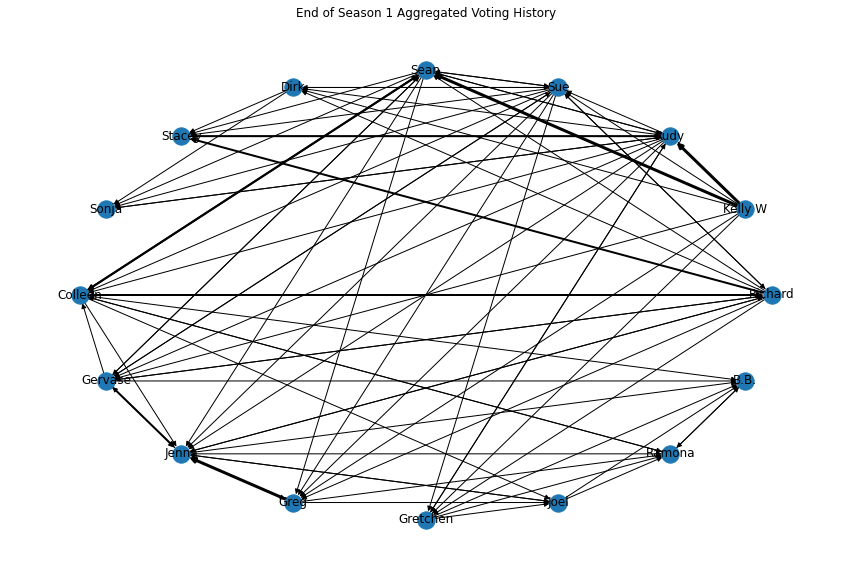

In [72]:
from collections import Counter

d = seasonstats[['Contestants','TCV']].dropna()
y = list(d.itertuples(index=False, name=None))
p = list(Counter(y).items())

allVotesAttr = {}

for i in range(len(p)):
    tmp = {}
    allVotesAttr[p[i][0]] = tmp

    tmp["NumVotes"] = p[i][1]
    
widths = list(nx.get_edge_attributes(G,'NumVotes').values())
n_color = list(nx.get_node_attributes(G,'Sex').values())

G = nx.DiGraph()
fig = plt.figure(figsize=(15, 10))

G.add_nodes_from(d["Contestants"].unique())
G.add_edges_from(y)

nx.set_edge_attributes(G, allVotesAttr)
nx.set_node_attributes(G, n_attr)


plt.title('End of Season 1 Aggregated Voting History')
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, 
        width=widths)

"""Need to add color to nodes"""
"""can do some normalization"""

In [70]:
network_summary(G)

GENERAL
	number of nodes: 16
	number of edges: 80
	is_directed: True
	is_weighted: False
	is_tree: False
	density: 0.3333333333333333
	average_clustering coefficient:  0.4302594944502999
	degree_assortativity_coefficient:  -0.06570892528953329
DEGREE
	min: 5
	mean: 10.0
	median: 8.5
	max: 16
	top nodes: ['Sue', 'Rudy', 'Sean', 'Jenna', 'Richard', 'Colleen']
	           [16, 15, 14, 14, 13, 12]
CLOSENESS CENTRALITY
	min: 0.0
	mean: 0.49597855817182257
	median: 0.5086206896551724
	max: 0.6521739130434783
	top nodes: ['Jenna', 'Colleen', 'Sean', 'Gervase', 'Greg', 'Ramona']
	           [0.6521739130434783, 0.625, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556]
BETWEEN CENTRALITY
	min: 0.0
	mean: 0.061011904761904774
	median: 0.03904761904761905
	max: 0.1743650793650794
	top nodes: ['Rudy', 'Colleen', 'Richard', 'Jenna', 'Sean', 'Ramona']
	           [0.1743650793650794, 0.15746031746031747, 0.133968253968254, 0.13261904761904764, 0.08595238095238096, 0.0844

In [202]:
seasonstats[(seasonstats['Merged'] == True)]["Episode"].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14])

In [215]:
measures = [
    "NumberOfNodes",
    "NumberOfEdges",
    "Density",
    "AverageClusteringCoefficient",
    "DegreeAssortativityCoefficient",
    "DegreeMin",
    "DegreeMean",
    "DegreeMedian",
    "DegreeMax",
    "ClosenessMin",
    "ClosenessMean",
    "ClosenessMedian",
    "ClosenessMax",
    "BetweenMin",
    "BetweenMean",
    "BetweenMedian",
    "BetweenMax"
]

In [216]:
df = pd.DataFrame(index=pd.Index(measures))


In [236]:
def getMeasures(G):
    epMeasures = []
    epMeasures.append(len(list(G.nodes)))
    epMeasures.append(len(list(G.edges)))

    epMeasures.append(nx.density(G))
    epMeasures.append(nx.average_clustering(G))
    # epMeasures.append(nx.degree_assortativity_coefficient(G))


    nodemeasures=np.array(list(dict(nx.degree(G)).values())); #print(x2)
    epMeasures.append(min(nodemeasures))
    epMeasures.append(np.mean(nodemeasures))
    epMeasures.append(np.median(nodemeasures))
    epMeasures.append(max(nodemeasures))

    closemeasures=np.array(list(dict(nx.closeness_centrality(G)).values())); #print(x2)
    epMeasures.append(min(closemeasures))
    epMeasures.append(np.mean(closemeasures))
    epMeasures.append(np.median(closemeasures))
    epMeasures.append(max(closemeasures))

    betweenmeasures=np.array(list(dict(nx.betweenness_centrality(G)).values())); #print(x2)
    epMeasures.append(min(betweenmeasures))
    epMeasures.append(np.mean(betweenmeasures))
    epMeasures.append(np.median(betweenmeasures))
    epMeasures.append(max(betweenmeasures))
    return epMeasures

In [249]:
def measuresMerged(seasonstats):
    '''
    PARAMETERS
        seasonstats: DataFrame
            seasonstats is the full imported dataframe of the season statistics
        nodecolor: str
            a column name to color the nodes of the network
        
    RETURNS
        plots a directional graph of each tribal council for each episode during the merged tribal period
    '''
    
    measures = [
        "NumberOfNodes",
        "NumberOfEdges",
        "Density",
        "AverageClusteringCoefficient",
        # "DegreeAssortativityCoefficient",
        "DegreeMin",
        "DegreeMean",
        "DegreeMedian",
        "DegreeMax",
        "ClosenessMin",
        "ClosenessMean",
        "ClosenessMedian",
        "ClosenessMax",
        "BetweenMin",
        "BetweenMean",
        "BetweenMedian",
        "BetweenMax"
    ]
    df = pd.DataFrame(index=pd.Index(measures))
    
    epList = seasonstats[(seasonstats['Merged'] == True)]['Episode'].unique()
    season = str(seasonstats['Season'].unique()[0])
    # tribeName = seasonstats[(seasonstats['Merged'] == True)]['Tribe'].unique()[0]
    lastEp = max(epList)
    
    for i in range(len(epList)):
        if epList[i] != lastEp:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))

            G = nx.DiGraph()
            G.add_edges_from(indvVotes)
            
            df[ep]=getMeasures(G)
        else:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))
            e = []
            
            for i in range(len(indvVotes)):
                if str(indvVotes[i][1]) != 'nan':
                    e.append(indvVotes[i])

            n = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)]['Contestants'].unique()
            
            G = nx.DiGraph()
            G.add_nodes_from(n)
            G.add_edges_from(e)
            df[ep]=getMeasures(G)
    
    return df.T

In [263]:
measures = measuresMerged(seasonstats)
list(measures.columns)

['NumberOfNodes',
 'NumberOfEdges',
 'Density',
 'AverageClusteringCoefficient',
 'DegreeMin',
 'DegreeMean',
 'DegreeMedian',
 'DegreeMax',
 'ClosenessMin',
 'ClosenessMean',
 'ClosenessMedian',
 'ClosenessMax',
 'BetweenMin',
 'BetweenMean',
 'BetweenMedian',
 'BetweenMax']

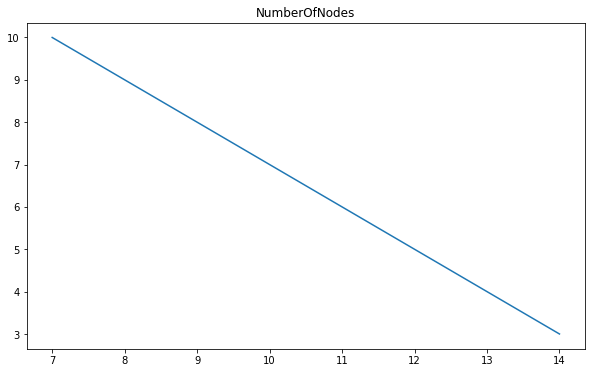

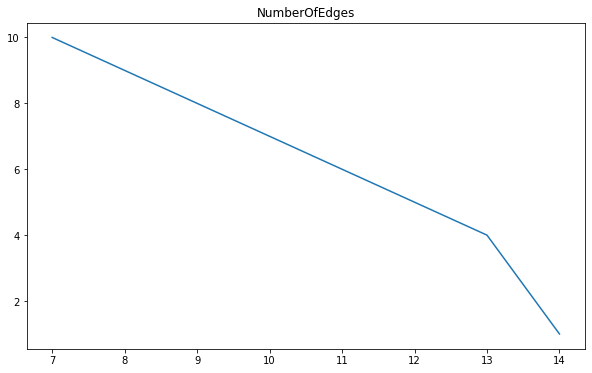

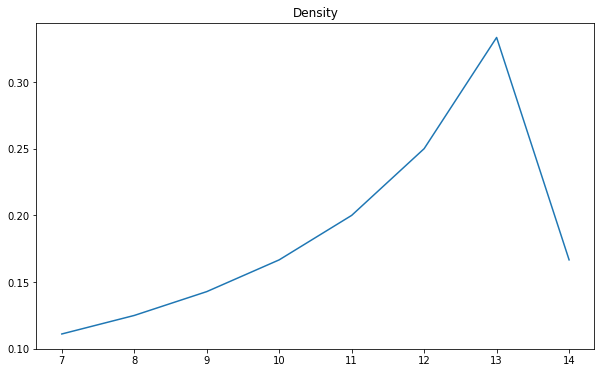

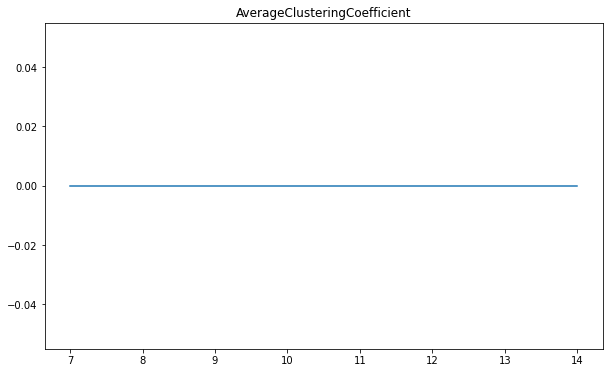

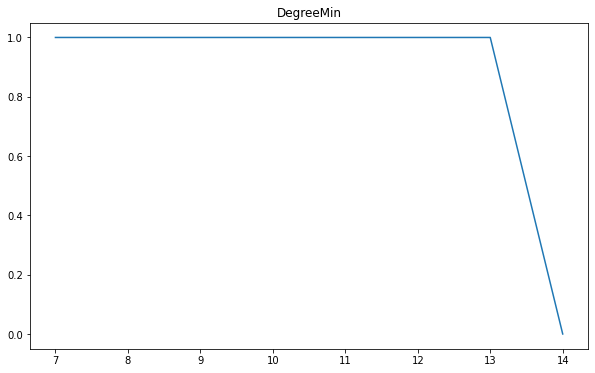

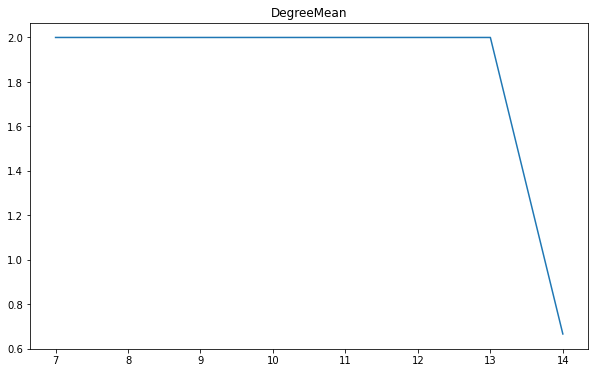

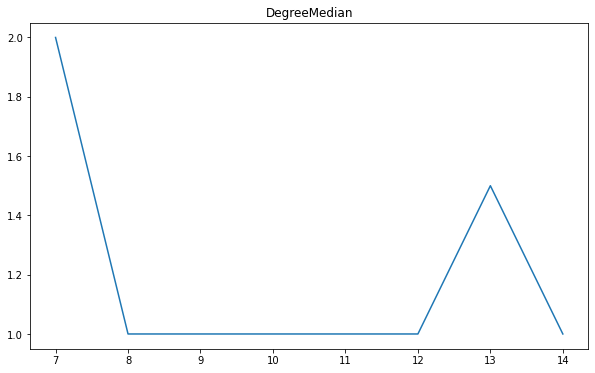

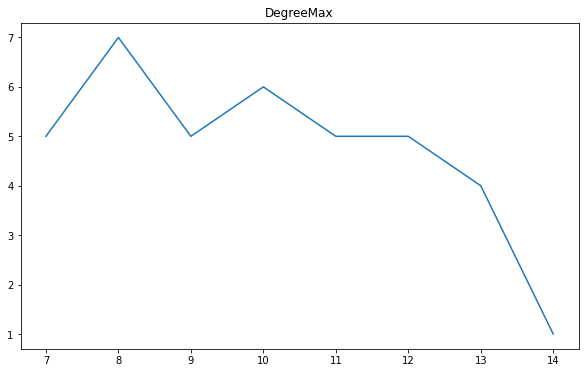

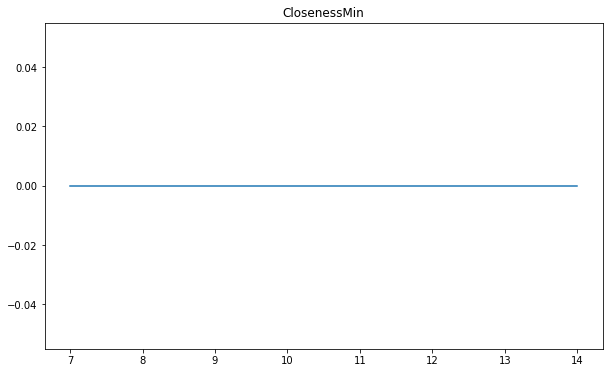

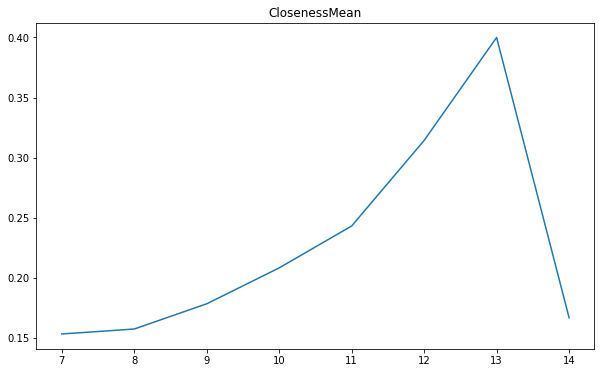

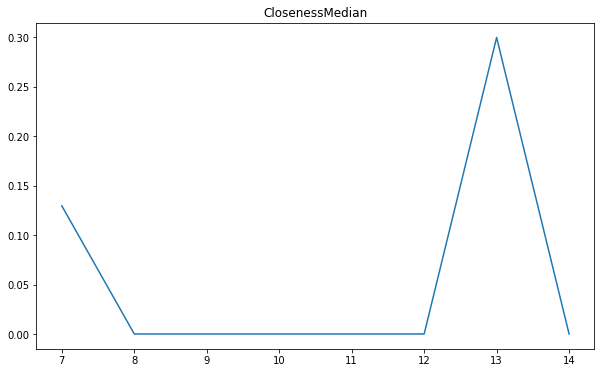

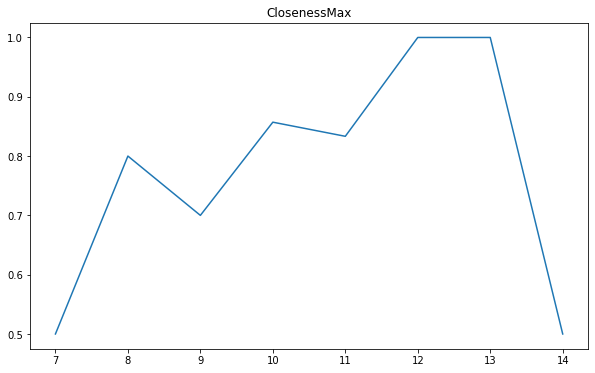

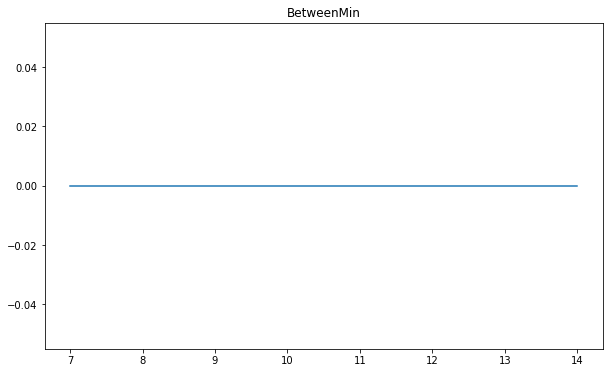

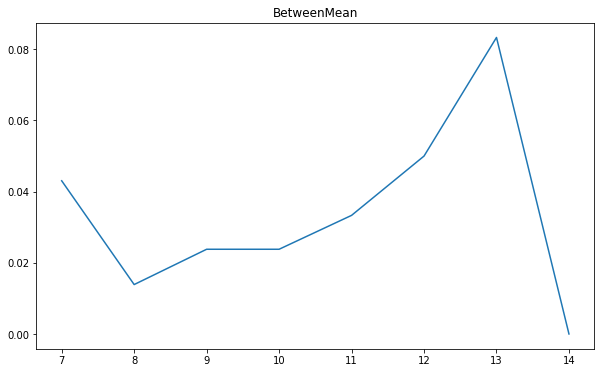

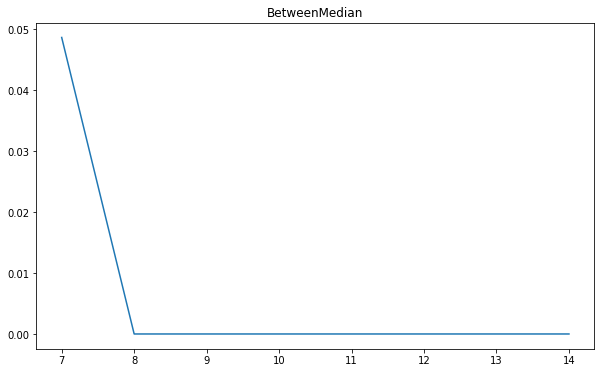

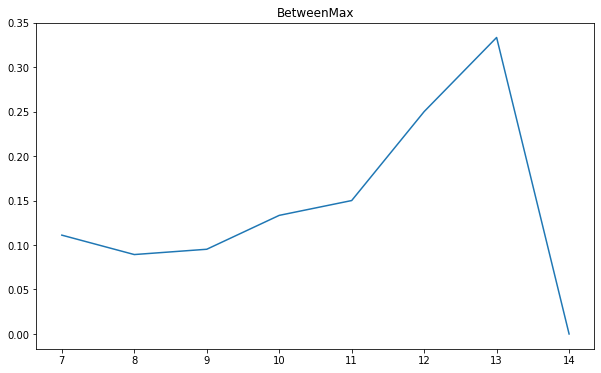

In [266]:
measuresNames = [
        "NumberOfNodes",
        "NumberOfEdges",
        "Density",
        "AverageClusteringCoefficient",
        # "DegreeAssortativityCoefficient",
        "DegreeMin",
        "DegreeMean",
        "DegreeMedian",
        "DegreeMax",
        "ClosenessMin",
        "ClosenessMean",
        "ClosenessMedian",
        "ClosenessMax",
        "BetweenMin",
        "BetweenMean",
        "BetweenMedian",
        "BetweenMax"
    ]
for i in range(len(list(measures.columns))):
    plt.figure(figsize=(10,6))
    plt.plot(measures[measuresNames[i]])
    plt.title(measuresNames[i])
    plt.show()

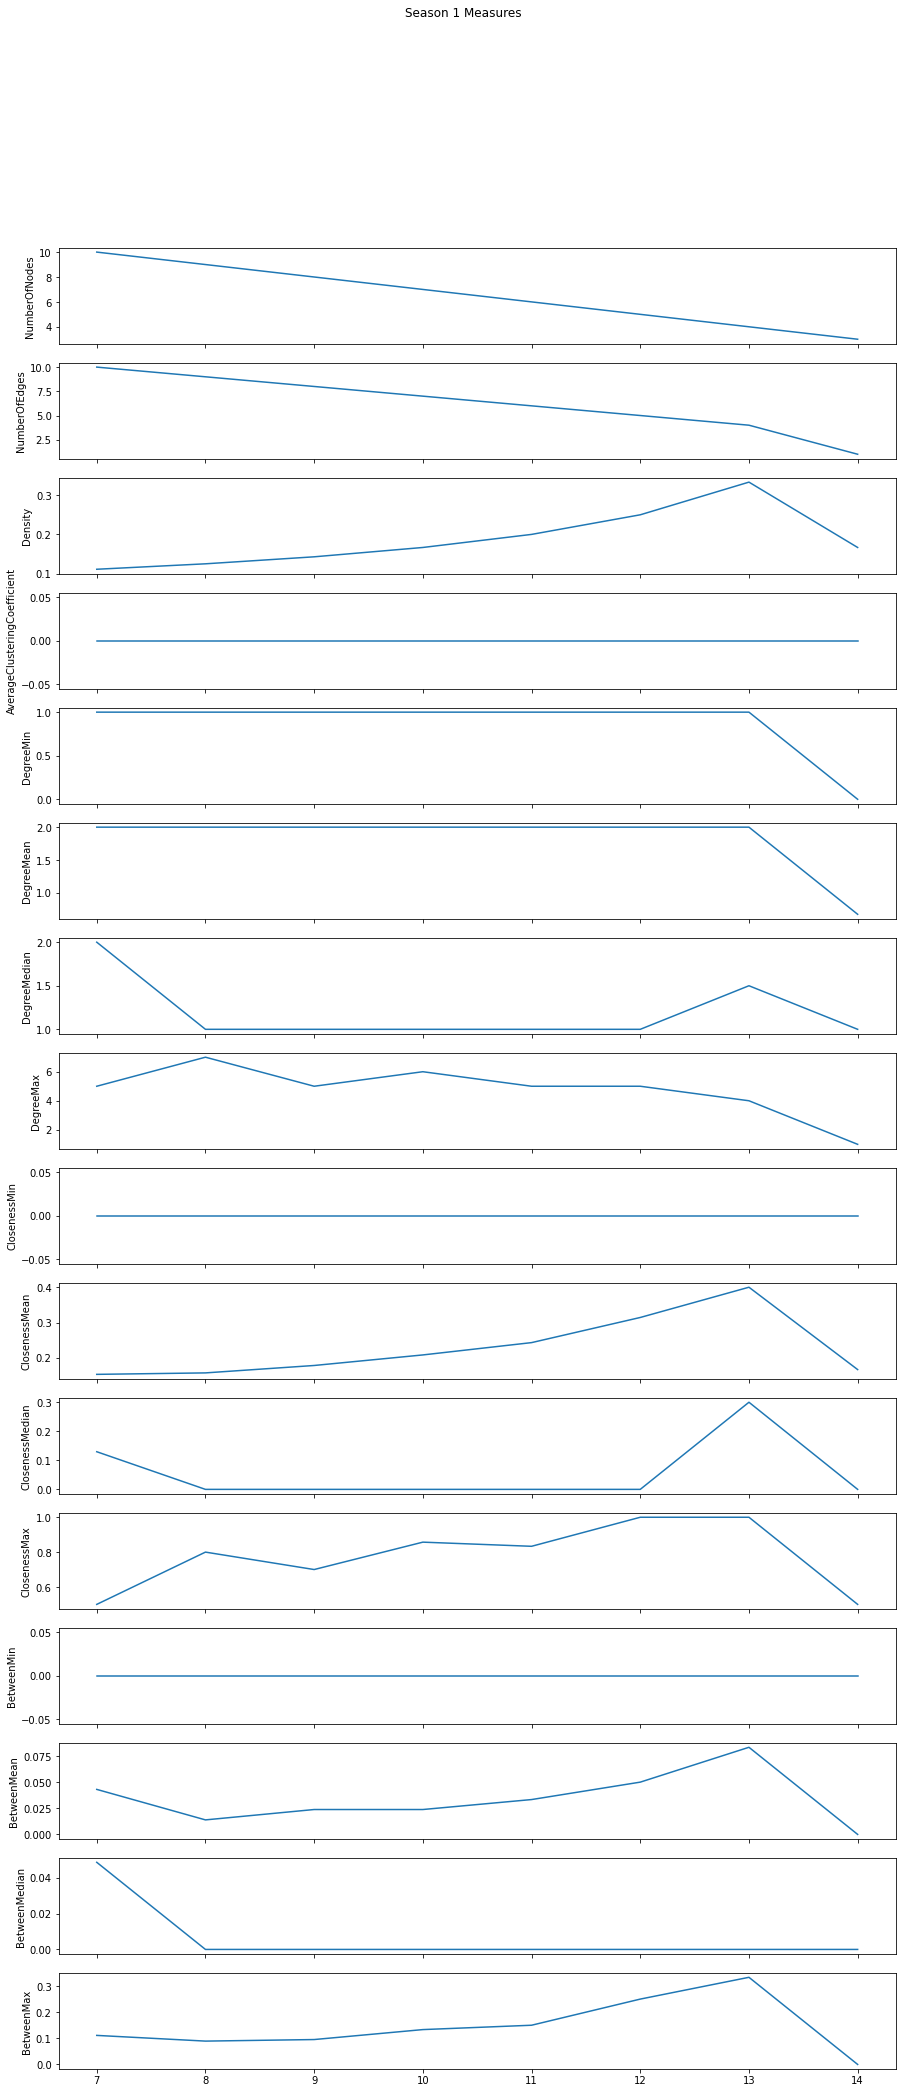

In [285]:
# fig = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(len(measuresNames), sharex=True)
fig.set_size_inches(15, 33.5)
fig.suptitle('Season 1 Measures')
for i in range(len(measuresNames)):
    axs[i].plot(measures[measuresNames[i]])
    axs[i].set_ylabel(measuresNames[i])
    # axs[1].plot(x, 0.3 * y, 'o')
    # axs[2].plot(x, y, '+')
    


In [197]:
def degree_histogram_plot(G):
    #COMPUTE DEGREE: --> "LIST" WITH NODE DEGREES
    G_DEGREE=G.degree(); #print(G_DEGREE,G_DEGREE[5],type(G_DEGREE)) 

    #LABELS (DICT)
    labels={}
    for n,d in G_DEGREE: labels[n]=d #str(n)+"-"+str(d) 


    #SORT DEGREE AND STORE IN LIST 
    degree_sequence = sorted((d for n, d in G_DEGREE), reverse=True)
    dmax = max(degree_sequence)   #MAX DEGREE

    #INITIALIZE MPL FIGURE+AX
    fig = plt.figure("Degree of a random graph", figsize=(10, 10))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    #PLOT NETWORK IN UPPER GRID SPACES 
    ax0 = fig.add_subplot(axgrid[0:3, :])
    pos = nx.spring_layout(G)
    nx.draw(G,
        with_labels=True,
        labels=labels,
        node_color='blue',
        node_size=500,
        font_color='white',
        font_size=16,
        pos=pos,ax=ax0
        )
    ax0.set_title("Network Graph: G")


    #PLOT RANK (IMPORTANCE BASED ON DEGREE) VS DEGREE)
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    #PLOT RANK HISTOGRAM
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    ax0.set_aspect('equal', 'box')
    fig.tight_layout()
    plt.show()

In [199]:
def getMergedHistograms(seasonstats):
    '''
    PARAMETERS
        seasonstats: DataFrame
            seasonstats is the full imported dataframe of the season statistics
        
    RETURNS
        plots histogram statistics of each merged tribal council
    '''
    epList = seasonstats[(seasonstats['Merged'] == True)]['Episode'].unique()
    season = str(seasonstats['Season'].unique()[0])
    tribeName = seasonstats[(seasonstats['Merged'] == True)]['Tribe'].unique()[0]
    lastEp = max(epList)
    
    for i in range(len(epList)):
        if epList[i] != lastEp:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))

            G = nx.DiGraph()
            G.add_edges_from(indvVotes)

            degree_histogram_plot(G)

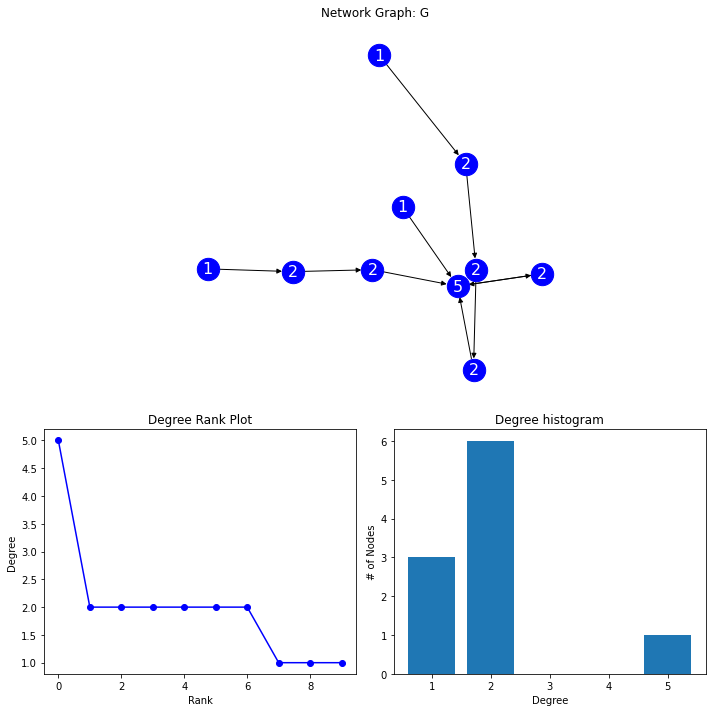

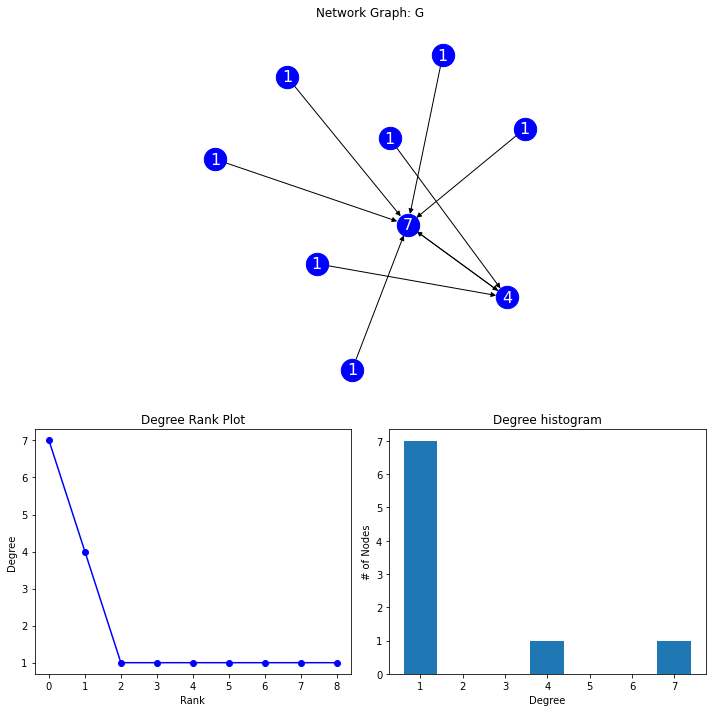

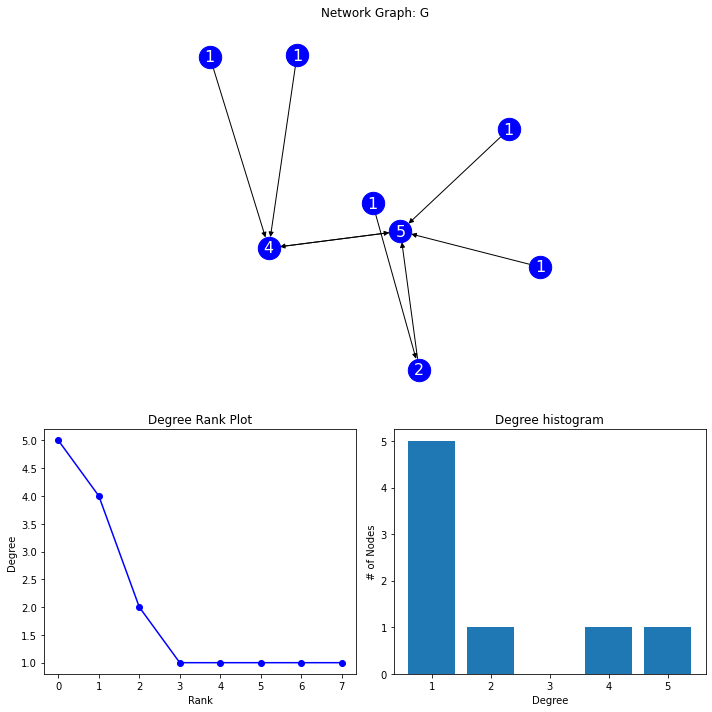

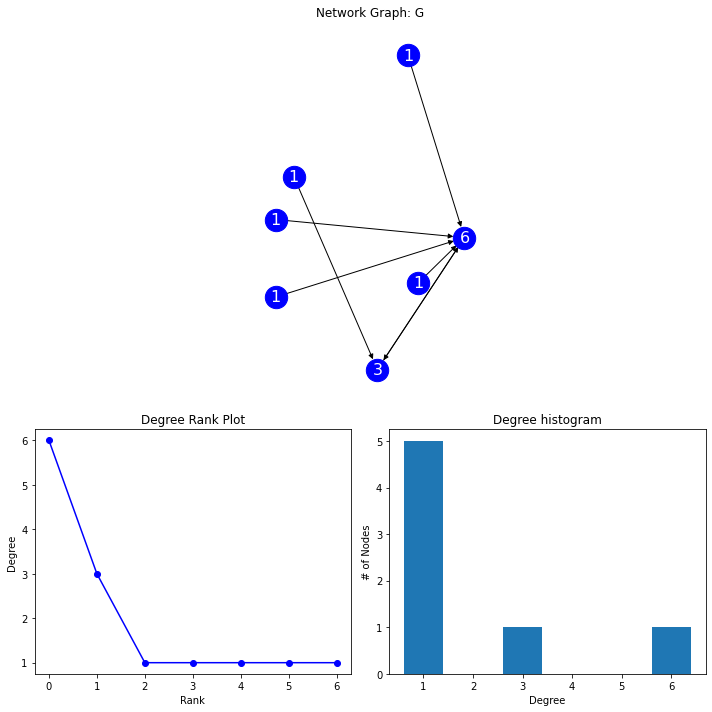

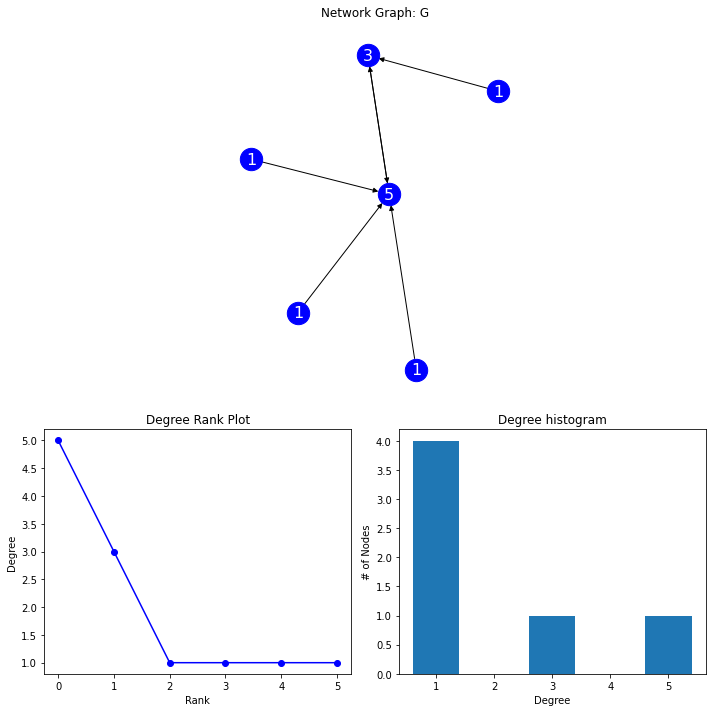

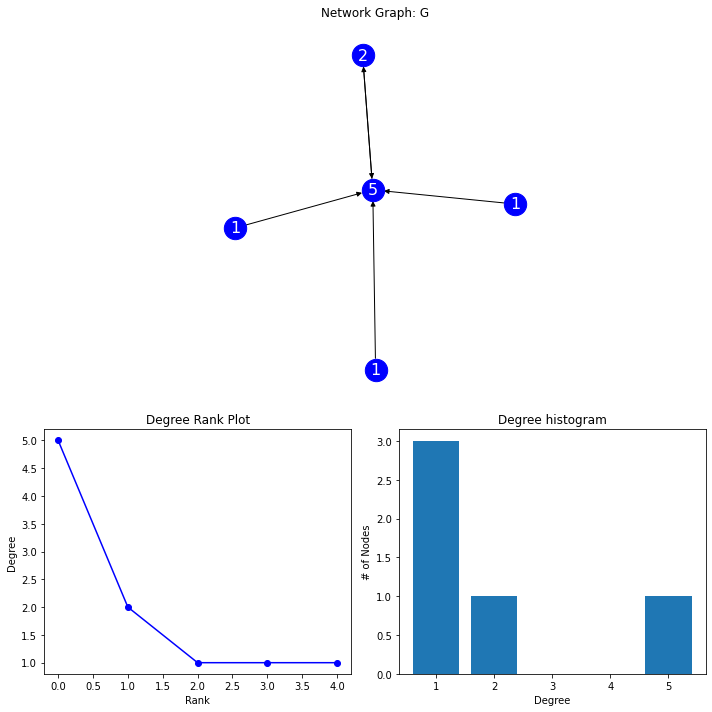

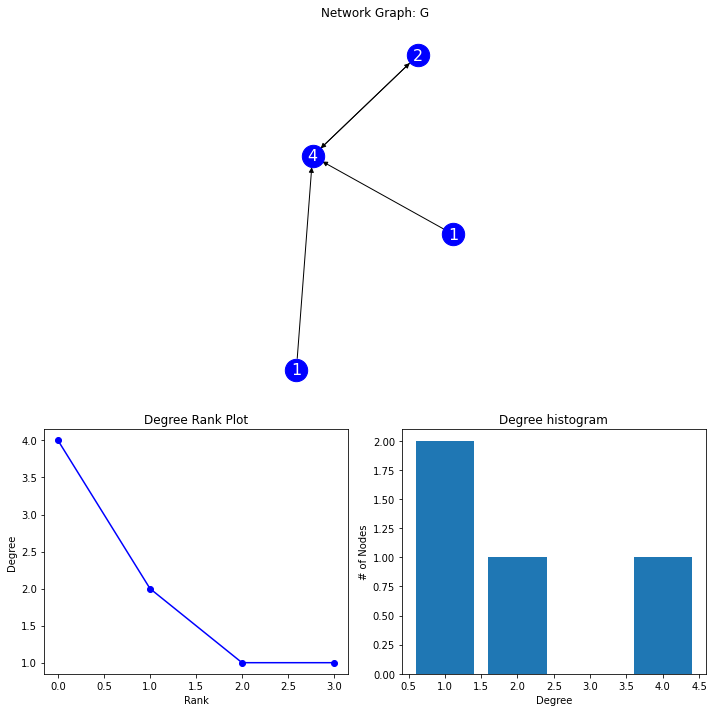

In [200]:
getMergedHistograms(seasonstats)